In [1]:
##########################################################################
# Quantum Binary classifier using Keras
# Nikolaos Schetakis , nsxetakis@yahoo.gr
###########################################################################

import pennylane as qml
import tensorflow as tf
from pennylane import numpy as np

N=500 #NUMBER OF SAMPLES
noise=0.01 # applicable for moon and circle datasets
test_size=0.15 #train/test split ratio
n_qubits = 2 # Number of qubits
blocks = 3  #number of blocks (AngleEmbedding and StronglyEntanglingLayers is one block )
layers = 2  #layers per block
epochsh = 12 #training epochs
batch_size = 20
np.random.seed(42)
learning_rate = 0.2 #for optimizer

In [2]:
from sklearn.datasets import make_moons , make_circles

# This part of the code is similar to the one written by Adrián Pérez-Salinas, Alba Cervera-Lierta, Elies Gil-Fuster, and José I. Latorre.
# https://github.com/AdrianPerezSalinas/universal_qlassifier/blob/master/data_gen.py
# Make a dataset of points inside and outside of a circle
def _circle(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    """
    Generates a dataset of points with 1/0 labels inside a given radius.

    Args:
        samples (int): number of samples to generate
        center (tuple): center of the circle
        radius (float: radius of the circle

    Returns:
        Xvals (array[tuple]): coordinates of points
        yvals (array[int]): classification labels
    """
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if np.linalg.norm(x - center) < radius:
            y = 1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)


def _squares(samples):
    data=[]
    Xvals, yvals = [], []
    dim=2
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        if x[0] < 0 and x[1] < 0: y = 0
        if x[0] < 0 and x[1] > 0: y = 1
        if x[0] > 0 and x[1] < 0: y = 1
        if x[0] > 0 and x[1] > 0: y = 0        
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)  
    



    
def _wavy_lines0(samples, freq = 1):
    Xvals, yvals = [], []
    def fun1(s):
        return s + np.sin(freq * np.pi * s)
    
    def fun2(s):
        return -s + np.sin(freq * np.pi * s)
    data=[]
    dim=2
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        if x[1] < fun1(x[0]) and x[1] < fun2(x[0]): y = 0
        if x[1] < fun1(x[0]) and x[1] > fun2(x[0]): y = 1
        if x[1] > fun1(x[0]) and x[1] < fun2(x[0]): y = 1
        if x[1] > fun1(x[0]) and x[1] > fun2(x[0]): y = 0        
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)
      
    
def _wavy_lines1(samples, freq = 1):
    Xvals, yvals = [], []
    def fun1(s):
        return s + np.sin(freq * np.pi * s)
    
    def fun2(s):
        return -s + np.sin(freq * np.pi * s)
    data=[]
    dim=2
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        if x[1] < fun1(x[0]) and x[1] < fun2(x[0]): y = 0
        if x[1] < fun1(x[0]) and x[1] > fun2(x[0]): y = 1
        if x[1] > fun1(x[0]) and x[1] < fun2(x[0]): y = 0
        if x[1] > fun1(x[0]) and x[1] > fun2(x[0]): y = 1        
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)
       

def _wavy_lines2(samples, freq = 1):
    Xvals, yvals = [], []
    def fun1(s):
        return s + np.sin(freq * np.pi * s)
    
    def fun2(s):
        return -s + np.sin(freq * np.pi * s)
    data=[]
    dim=2
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        if x[1] < fun1(x[0]) and x[1] < fun2(x[0]): y = 0
        if x[1] < fun1(x[0]) and x[1] > fun2(x[0]): y = 1
        if x[1] > fun1(x[0]) and x[1] < fun2(x[0]): y = 1
        if x[1] > fun1(x[0]) and x[1] > fun2(x[0]): y = 1        
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)
       
    
    
def _threecircles(samples):
    Xvals, yvals = [], []
    centers = np.array([[-1, 1], [1, 0], [-.5, -.5]])
    radii = np.array([1, np.sqrt(6/np.pi - 1), 1/2]) 
    data=[]
    dim = 2
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        y = 0
        for j, (c, r) in enumerate(zip(centers, radii)): 
            if np.linalg.norm(x - c) < r:
                y = j + 1 
                
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)   
    
    
def _non_convex(samples, freq = 1, x_val = 2, sin_val = 1.5):
    Xvals, yvals = [], []
    def fun(s):
        return -x_val * s + sin_val * np.sin(freq * np.pi * s)
    
    data = []
    dim = 2
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        if x[1] < fun(x[0]): y = 0
        if x[1] > fun(x[0]): y = 1
        data.append([x, y])

        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)
    
    

def _crown(samples):
    Xvals, yvals = [], []
    c = [[0,0],[0,0]]
    r = [np.sqrt(.8), np.sqrt(.8 - 2/np.pi)]
    data = []
    dim = 2
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        if np.linalg.norm(x - c[0]) < r[0] and np.linalg.norm(x - c[1]) > r[1]:
            y = 1
        else: 
            y=0
        data.append([x, y])
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)


def _circle2(samples):
    Xvals, yvals = [], []
    centers = [[0,0],[0,0]]
    radii = [np.sqrt(.8 - 2/np.pi), np.sqrt(.8)]
    data = []
    dim = 2
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        y=0
        for j,(r,c) in enumerate(zip(radii, centers)):
            if np.linalg.norm(x - c) > r:
                y = j + 1
        data.append([x, y])
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)



In [3]:
problems = ['circle', 'squares', 'wavy_lines0', 'wavy_lines1', 'wavy_lines2',
            'non convex', 'crown',  'squares',  'circle2']


def data_generator(problem, samples=None):
    """
    This function generates the data for a problem
    """
    
    if problem not in problems:
        raise ValueError('problem must be one of {}'.format(problems))

    if problem == 'circle':
        X, y = _circle(samples)
        
    if problem == '3 circles':
        X, y = _3_circles(samples)
        
    if problem == 'wavy_lines0':
        X, y = _wavy_lines0(samples)
        
    if problem == 'wavy_lines1':
        X, y = _wavy_lines1(samples)
        
    if problem == 'wavy_lines2':
        X, y = _wavy_lines2(samples)
        
    if problem == 'squares':
        X, y = _squares(samples)
        
    if problem == 'sphere':
        X, y = _sphere(samples)
        
    if problem == 'non convex':
        X, y = _non_convex(samples)
        
    if problem == 'crown':
        X, y = _crown(samples)
        
    if problem == 'circle2':
        X, y = _tricrown(samples)
        
    if problem == 'hypersphere':
        X, y = _hypersphere(samples)
    
        
    return X, y     
        
        


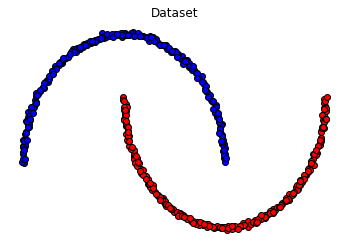

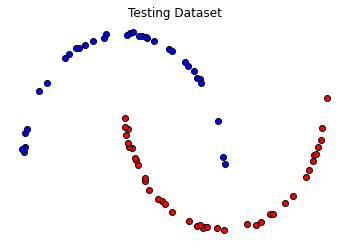

In [4]:
#----------------------------------------------------------------------------------------------------
# CHOOSE A DATASET , uncomment to select
#----------------------------------------------------------------------------------------------------
#X,y = data_generator("circle", N)
#X,y = data_generator("circle2", N)
#X,y = data_generator("non convex", N)
#X,y = data_generator("squares", N)
#X,y = data_generator("wavy_lines2", N)
#X,y = data_generator("crown", N)
#X, y = make_circles(n_samples=N, noise=noise)
X, y = make_moons(n_samples=N, noise=noise)

#----------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------


#Normalize dataset from -pi to pi
from sklearn.preprocessing import StandardScaler , minmax_scale
X = minmax_scale(X, feature_range=(-np.pi, np.pi))

import matplotlib.pyplot as plt
plt.figure()
plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0], c="b", marker="o", edgecolors="k")
plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], c="r", marker="o", edgecolors="k")
plt.title("Dataset")
plt.axis('off')
plt.show()

#train/test split 
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

plt.figure()
plt.scatter(X_test[:, 0][y_test == 0], X_test[:, 1][y_test == 0], c="b", marker="o", edgecolors="k")
plt.scatter(X_test[:, 0][y_test == 1], X_test[:, 1][y_test == 1], c="r", marker="o", edgecolors="k")
plt.title("Testing Dataset")
plt.axis('off')
plt.show()

In [5]:
#Plots

def prediction_grid():
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    import numpy as np
    y_pred1=np.array(y_pred[:,0])
    #Predictions Grid 
    from matplotlib import pyplot
    from numpy import where
    from numpy import meshgrid
    from numpy import arange
    from numpy import hstack
    min1, max1 = X[:, 0].min()-0.1, X[:, 0].max()+0.1
    min2, max2 = X[:, 1].min()-0.1, X[:, 1].max()+0.1
    x1grid = arange(min1, max1, 0.2)
    x2grid = arange(min2, max2, 0.2)
    xx, yy = meshgrid(x1grid, x2grid)
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    grid = hstack((r1,r2))

    # make predictions for the grid
    yhat = modelh.predict_classes(grid)
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)

    plt.scatter(
    X_test[:, 0][y_pred1 == 0],
    X_test[:, 1][y_pred1 == 0],
    c="b",s=100,
    marker="o",
    edgecolors="k",
    label="class 0 predictions ",
    )

    plt.scatter(
    X_test[:, 0][y_pred1 == 1],
    X_test[:, 1][y_pred1 == 1],
    c="r",s=100,
    marker="o",
    edgecolors="k",
    label="class 1 predictions ",
    )

    plt.scatter(
    X_test[:, 0][y_test == 0],
    X_test[:, 1][y_test == 0],
    c="b",s=100,
    marker="x",
    edgecolors="k",
    label="class 0 test ",
    )

    plt.scatter(
    X_test[:, 0][y_test == 1],
    X_test[:, 1][y_test == 1],
    c="r",s=100,
    marker="x",
    edgecolors="k",
    label="class 1 test",
    )
# plot decision regions
    cnt = pyplot.contourf(xx, yy, zz, cmap='RdBu_r',levels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1],alpha=0.8, extend="both")
    plt.contour(xx, yy,zz, levels=[0.5], colors=("black",), linestyles=("--",), linewidths=(2.8,))
    plt.title("Predictions Grid, predictions vs test data")
    plt.axis('off')
    #plt.text(1,2.8,round(roc_auc[2],2), fontsize=24)
    #plt.legend()
    #plt.colorbar(cnt, ticks=[0, 0.5, 1])
    
    
    
def prediction_grid1():
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    import numpy as np
    y_pred1=np.array(y_pred[:,0])
    #Predictions Grid 
    from matplotlib import pyplot
    from numpy import where
    from numpy import meshgrid
    from numpy import arange
    from numpy import hstack
    min1, max1 = X[:, 0].min()-0.1, X[:, 0].max()+0.1
    min2, max2 = X[:, 1].min()-0.1, X[:, 1].max()+0.1
    x1grid = arange(min1, max1, 0.2)
    x2grid = arange(min2, max2, 0.2)
    xx, yy = meshgrid(x1grid, x2grid)
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    grid = hstack((r1,r2))

    # make predictions for the grid
    yhat = modelh.predict_classes(grid)
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)


    plt.scatter(
    X_test[:, 0][y_test == 0],
    X_test[:, 1][y_test == 0],
    c="b",s=100,
    marker="o",
    edgecolors="k",
    label="class 0 test ",
    )

    plt.scatter(
    X_test[:, 0][y_test == 1],
    X_test[:, 1][y_test == 1],
    c="r",s=100,
    marker="o",
    edgecolors="k",
    label="class 1 test",
    )
# plot decision regions
    cnt = pyplot.contourf(xx, yy, zz, cmap='RdBu_r',levels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1],alpha=0.8, extend="both")
    plt.contour(xx, yy,zz, levels=[0.5], colors=("black",), linestyles=("--",), linewidths=(2.8,))
    plt.title("Predictions Grid & test dataset")
    plt.axis('off')
    #plt.text(1,2.8,round(roc_auc[2],2), fontsize=24)
    #plt.legend()
    #plt.colorbar(cnt, ticks=[0, 0.5, 1])
    
    
    
    
    
def AUC_roc_plot():    
    from sklearn.metrics import roc_curve , auc
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(y_test)):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
    lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example Ν=10 steps')
    plt.legend(loc="lower right")
    plt.show()
    auc_score=roc_auc_score(y_test,y_pred) 
    
    # Confusion matrix
    confusion_matrix(y_test, y_pred)
    print("auc score: ", round(auc_score,3))

In [6]:
qml.enable_tape()
dev = qml.device("default.qubit.tf", wires=n_qubits)

@qml.qnode(dev, interface="tf", grad_method="backprop")
def qnode(inputs, weights):
    for i in range(blocks):
        qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
        qml.templates.StronglyEntanglingLayers(weights[i], wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weights_shape = (blocks, layers, n_qubits, 3)
weights = tf.Variable(np.random.random(weights_shape))
inputs = tf.constant(np.random.random(n_qubits))
print("Output of QNode:", qnode(inputs, weights).numpy())
# Optionally convert to Keras layer:
tf.keras.backend.set_floatx("float64")
weight_shapes = {"weights": weights_shape}

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, n_qubits)
clayerf = tf.keras.layers.Dense(1, activation="sigmoid")

inputs = tf.constant(np.random.random((batch_size, n_qubits)))
print("Output of quantum layer:\n", qlayer(inputs).numpy())

Output of QNode: [0.70476462 0.74584144]
Output of quantum layer:
 [[ 0.49658149 -0.0815463 ]
 [ 0.83367633 -0.18329074]
 [ 0.67873658  0.15480431]
 [ 0.49033472  0.28399231]
 [ 0.53783504  0.11684019]
 [ 0.6329364   0.07182687]
 [ 0.52687269  0.02545908]
 [ 0.75732788 -0.06050717]
 [ 0.74438296 -0.18928971]
 [ 0.43325384 -0.05216964]
 [ 0.73625251 -0.10592379]
 [ 0.63373926 -0.01624123]
 [ 0.63494335 -0.03649298]
 [ 0.7451847  -0.15798833]
 [ 0.68472851 -0.14640314]
 [ 0.50778629  0.21276685]
 [ 0.77446479 -0.07945721]
 [ 0.45240963  0.26677485]
 [ 0.42527356 -0.10409464]
 [ 0.59851976 -0.19684968]]


In [7]:
from keras.callbacks import EarlyStopping
opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
modelh = tf.keras.models.Sequential([qlayer,clayerf])
es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=10, verbose=1)
modelh.compile(opt, loss='mse',metrics=['accuracy'])

In [8]:
historyh = modelh.fit(X_train, y_train,validation_data=(X_test, y_test), callbacks=[es], epochs=epochsh, batch_size=batch_size)

Epoch 1/6
22/22 [==============================] - 35s 2s/step - loss: 0.2472 - accuracy: 0.6024 - val_loss: 0.1974 - val_accuracy: 0.7333
Epoch 2/6
22/22 [==============================] - 36s 2s/step - loss: 0.1914 - accuracy: 0.7482 - val_loss: 0.1719 - val_accuracy: 0.7867
Epoch 3/6
22/22 [==============================] - 32s 1s/step - loss: 0.1655 - accuracy: 0.7765 - val_loss: 0.1527 - val_accuracy: 0.8267
Epoch 4/6
22/22 [==============================] - 33s 1s/step - loss: 0.1456 - accuracy: 0.8329 - val_loss: 0.1333 - val_accuracy: 0.8533
Epoch 5/6
22/22 [==============================] - 34s 2s/step - loss: 0.1256 - accuracy: 0.8753 - val_loss: 0.1154 - val_accuracy: 0.8667
Epoch 6/6
22/22 [==============================] - 33s 2s/step - loss: 0.1089 - accuracy: 0.8847 - val_loss: 0.1003 - val_accuracy: 0.8933


In [9]:
# Make predictions on X_test
y_pred = modelh.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


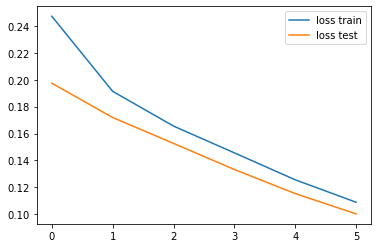

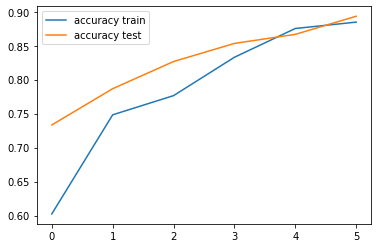

In [10]:
from matplotlib import pyplot
pyplot.plot(historyh.history['loss'], label='loss train')
pyplot.plot(historyh.history['val_loss'], label='loss test')
pyplot.legend()
pyplot.show()

pyplot.plot(historyh.history['accuracy'], label='accuracy train')
pyplot.plot(historyh.history['val_accuracy'], label='accuracy test')
#pyplot.plot(history.history['mse'], label='mse')
#pyplot.plot(history.history['mae'], label='mae')
pyplot.legend()
pyplot.show()

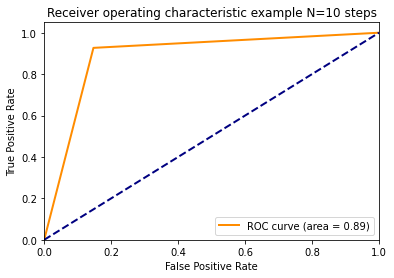

auc score:  0.89


In [11]:
AUC_roc_plot()

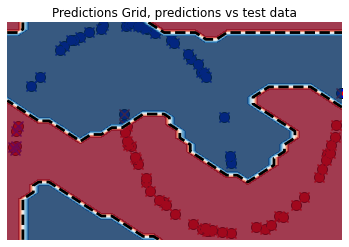

In [12]:
prediction_grid()

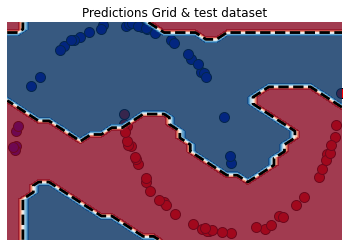

In [14]:
prediction_grid1()